# Deep Q Networks (DQN)

In [7]:
# Reference: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf
# https://github.com/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import argparse
from distutils.util import strtobool
import collections
import numpy as np
import gym
from gym.wrappers import TimeLimit, Monitor
from gym.spaces import Discrete, Box, MultiBinary, MultiDiscrete, Space
import time
import random
import os
import matplotlib.pyplot as plt

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env = gym.make('Humanoid-v2')
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

discrete_action_space_dim = 21
input_dim = env.observation_space.shape[0]
hidden_dim = 765
output_dim = env.action_space.shape[0] * discrete_action_space_dim
print (input_dim, output_dim)

376 357


In [9]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0)

In [10]:
# modified from https://github.com/seungeunrho/minimalRL/blob/master/dqn.py#
class ReplayBuffer():
    def __init__(self, buffer_limit):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        #print ("transition: ", len(transition))
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append(r)
            s_prime_lst.append(s_prime)
            done_mask_lst.append(done_mask)

        return np.array(s_lst), np.array(a_lst), \
               np.array(r_lst), np.array(s_prime_lst), \
               np.array(done_mask_lst)
    def flush(self):
        self.buffer.clear()
        
    def len(self):
        return (len(self.buffer))
        

# Multi Layer Percpetron architecture, to be used as a non-linear Q value function approximator
class QNetwork(nn.Module):
    def __init__(self, env):
        super(QNetwork, self).__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_1a = nn.Linear(hidden_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, output_dim)
        self.maxpool = nn.MaxPool1d(discrete_action_space_dim, stride=discrete_action_space_dim, return_indices=True)

    def forward(self, x, device):
        x = torch.FloatTensor(x).to(device)
        x = torch.tanh(self.fc_1(x))
        x = torch.tanh(self.fc_1a(x))
        x = self.fc_2(x)
        x1, indices = self.maxpool(x)
        return x1, indices

In [11]:
# Logic to discretise action space
n = discrete_action_space_dim
max_action = 0.4
min_action = -0.4
inc = (max_action - min_action)/ (n-1)
print (inc)
discrete_action_list = [min_action+inc*i for i in range(0, n)]
print (len(discrete_action_list))

0.04
21


In [60]:
# Helper function to get action from action index output of the Neural Net
def get_actions(action_indices):
    ret_actions = np.zeros(env.action_space.shape[0])
    for i in range(0, len(action_indices)):
        index = action_indices[i] - i*discrete_action_space_dim
        ret_actions[i] = discrete_action_list[index]
    return ret_actions

In [83]:
buffer_size = 100_000
lr = 9e-6


rb = ReplayBuffer(buffer_size)
q_network = QNetwork(env).to(device)
target_network = QNetwork(env).to(device)
q_network.apply(init_weights)
target_network.load_state_dict(q_network.state_dict())

optimizer = optim.RMSprop(q_network.parameters(), lr=lr)
print(device.__repr__())
print(q_network)
exploration_fraction = 0.5
target_network_frequency = 100
batch_size = 64
max_grad_norm = 1.0
gamma = 0.99


# Hyper params
n_iters = 30
steps_per_iter = 4000
phase = 'train'
max_step = 1000

device(type='cuda')
QNetwork(
  (fc_1): Linear(in_features=376, out_features=765, bias=True)
  (fc_1a): Linear(in_features=765, out_features=765, bias=True)
  (fc_2): Linear(in_features=765, out_features=357, bias=True)
  (maxpool): MaxPool1d(kernel_size=21, stride=21, padding=0, dilation=1, ceil_mode=False)
)


In [84]:
# To run for each episode
def agent_run(max_steps, global_step, epsilon, eval_mode):
    obs = env.reset()
    episode_reward = 0
    episode = 0
    step_count = 0

    for steps in range(max_steps):

        # Pick an action using epsilon-greedy policy
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_vals, action_indices = q_network.forward(obs[None, :], device)
            action = get_actions(action_indices.view((-1)))
            
        # Take the chosen action in the env and collect reward
        next_obs, reward, done, _ = env.step(action)
        episode_reward += reward

         # Add the (s, a, s', r, done) tuple to the replay-buffer
        rb.put((obs, action, reward, next_obs, done))

        # If enough samples in the replay buffer, start training on a randomly sampled batch
        if steps -  batch_size > 0:
            s_obs, s_actions, s_rewards, s_next_obses, s_dones = rb.sample(batch_size)
            with torch.no_grad():
                q_next_val, action_next_indices = target_network.forward(s_next_obses, device)
                target_max = q_next_val.sum()
                # compute target
                td_target = torch.Tensor(s_rewards).to(device) + gamma * target_max * (1 - torch.Tensor(s_dones).to(device))

            old_q, old_action = q_network.forward(s_obs, device)
            # Compute loss using target and the current q value
            loss = F.smooth_l1_loss(td_target, torch.sum(old_q, 1))

            # optimize the model
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(list(q_network.parameters()), max_grad_norm)
            optimizer.step()

        # update the target network based on update frequency
        if global_step % target_network_frequency == 0 and eval_mode==False:
            target_network.load_state_dict(q_network.state_dict())

        obs = next_obs
        step_count+=1

        # Keep interacting until agent reaches a terminal state.
        if done:
            break
    return step_count, episode_reward
      

In [85]:
### This is the actual train/eval loop.
# We run 10 episodes of evaluation for every 4000 steps (steps_per_iter) taken by the agent in the environment during training

start_time = time.time()

total_num_steps = 0
train_sum_returns = 0.
train_num_episodes = 0
eval_mode = False

train_avg_ret = []
train_ep_ret = []
eval_avg_ret = []
eval_ep_ret = []
epsilon = 0.9
decay_rate = 0.9975

for i in range(n_iters):
        # Perform the training phase, during which the agent learns
        if phase == 'train':
            train_step_count = 0
            while train_step_count <= steps_per_iter:
                eval_mode = False
                epsilon = max(epsilon*decay_rate, 0.1)
                
                # Run one episode
                train_step_length, train_episode_return = agent_run(max_step, i, epsilon, eval_mode)
                
                total_num_steps += train_step_length
                train_step_count += train_step_length
                train_sum_returns += train_episode_return
                train_num_episodes += 1

                train_average_return = train_sum_returns / train_num_episodes if train_num_episodes > 0 else 0.0
                
                train_avg_ret.append(train_average_return)
                train_ep_ret.append(train_episode_return)


        # Perform the evaluation phase -- no learning
        eval_sum_returns = 0.
        eval_num_episodes = 0
        eval_mode = True

        for _ in range(10):
            # Run one episode in eval mode
            eval_step_length, eval_episode_return = agent_run(max_step, i, 0, eval_mode)
            eval_sum_returns += eval_episode_return
            eval_num_episodes += 1

        eval_average_return = eval_sum_returns / eval_num_episodes if eval_num_episodes > 0 else 0.0
        eval_avg_ret.append(eval_average_return)
        eval_ep_ret.append(eval_episode_return)


        if phase == 'train':
            print('---------------------------------------')
            print('Iterations:', i + 1)
            print('Steps:', total_num_steps)
            print('Episodes:', train_num_episodes)
            print('EpisodeReturn:', round(train_episode_return, 2))
            print('AverageReturn:', round(train_average_return, 2))
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
        else:
            print('---------------------------------------')
            print('EvalEpisodes:', eval_num_episodes)
            print('EvalEpisodeReturn:', round(eval_episode_return, 2))
            print('EvalAverageReturn:', round(eval_average_return, 2))
            print('Time:', int(time.time() - start_time))
            print('---------------------------------------')
            

---------------------------------------
Iterations: 1
Steps: 4005
Episodes: 159
EpisodeReturn: 177.78
AverageReturn: 126.76
EvalEpisodes: 10
EvalEpisodeReturn: 156.76
EvalAverageReturn: 141.78
Time: 4
---------------------------------------
---------------------------------------
Iterations: 2
Steps: 8029
Episodes: 307
EpisodeReturn: 195.68
AverageReturn: 131.86
EvalEpisodes: 10
EvalEpisodeReturn: 129.44
EvalAverageReturn: 161.61
Time: 9
---------------------------------------
---------------------------------------
Iterations: 3
Steps: 12032
Episodes: 450
EpisodeReturn: 261.2
AverageReturn: 135.2
EvalEpisodes: 10
EvalEpisodeReturn: 101.38
EvalAverageReturn: 158.5
Time: 14
---------------------------------------
---------------------------------------
Iterations: 4
Steps: 16034
Episodes: 591
EpisodeReturn: 119.66
AverageReturn: 137.43
EvalEpisodes: 10
EvalEpisodeReturn: 197.08
EvalAverageReturn: 138.48
Time: 19
---------------------------------------
-----------------------------------

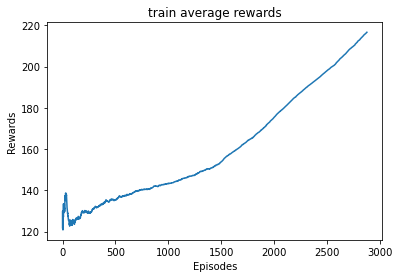

Text(0.5, 1.0, 'train episode rewards')

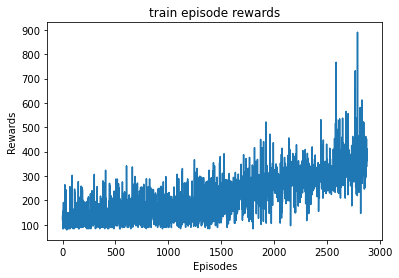

In [86]:
plt.show()
plt.plot(train_avg_ret[:])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train average rewards")

plt.show()
plt.plot(train_ep_ret[:])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("train episode rewards")

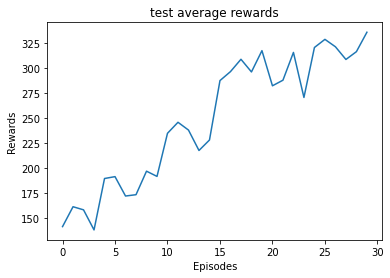

Text(0.5, 1.0, 'test episode rewards')

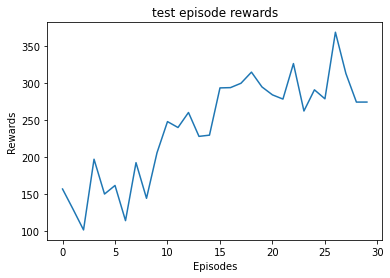

In [88]:
plt.show()
plt.plot(eval_avg_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test average rewards")

plt.show()
plt.plot(eval_ep_ret)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("test episode rewards")

In [89]:
flag = ""

In [90]:
from datetime import datetime

now = datetime.now() # current date and time
date_time = str(now.strftime("%m:%d:%Y_%H:%M:%S"))
print (date_time)


algo = "DQN"
path = "Results/" + algo + date_time + flag
np.save(path +"_train_avg", train_avg_ret)
np.save(path + "_test_avg", eval_avg_ret)
np.save(path +"_train_ep", train_ep_ret)
np.save(path + "_test_ep", eval_ep_ret)

12:11:2021_17:32:58


In [91]:
torch.save(q_network, path+"model")
torch.save(target_network, path+"model")